In [62]:
import torch as torch
import numpy as np
from scipy.io import loadmat
import pdb
import os
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm, colors

import sys
sys.path.append("..")
from project_bones import Projection_Client

%matplotlib inline
%load_ext autoreload
%autoreload 2

#original_joint_names_dataset = ['spine3', 'spine4', 'spine2', 'spine', 'pelvis', 'neck', 'head', 'head_top',
          #           'left_clavicle', 'left_shoulder', 'left_elbow','left_wrist', 'left_hand',  
           #          'right_clavicle', 'right_shoulder', 'right_elbow', 'right_wrist', 'right_hand', 
            #         'left_hip', 'left_knee', 'left_ankle', 'left_foot', 'left_toe', 'right_hip' , 
             #        'right_knee', 'right_ankle', 'right_foot', 'right_toe'] 
original_joint_names_dataset = ['spine3', 'spine4', 'spine2', 'spine', 'pelvis', 'neck', 'head', 'head_top',
                     'left_clavicle', 'left_shoulder', 'left_elbow','left_wrist', 'left_hand',  
                    'right_clavicle', 'right_shoulder', 'right_elbow', 'right_wrist', 'right_hand', 
                    'left_hip', 'left_knee', 'left_ankle', 'left_foot', 'left_toe', 'right_hip' , 
                    'right_knee', 'right_ankle', 'right_foot', 'right_toe'] 
joint_indices_dataset = [3, 1, 4, 5, 5, 2, 6, 7, 6, 9, 10, 11, 12, 6, 14, 15, 16, 17, 5, 19, 20, 21, 22, 5, 24, 25, 26, 27 ]

joint_names_mpi = ['head','neck','right_shoulder','right_elbow','right_wrist',
                'left_shoulder', 'left_elbow','left_wrist','right_hip','right_knee', 
                'right_ankle', 'left_hip', 'left_knee', 'left_ankle', 'spine']

bones_mpi = [[0, 1], [14, 1], #middle
            [1, 2], [2, 3], [3, 4], #right arm
            [1, 5], [5, 6], [6, 7],  #left arm
            [14, 8], [8, 9], [9, 10], #right leg
            [14, 11], [11, 12], [12, 13]] #left leg


def find_bone_map():
    joint_map = []
    for ind, value in enumerate(joint_names_mpi):
        joint_map.append(original_joint_names_dataset.index(value))
    return joint_map


def rearrange_bones_to_mpi(joints_unarranged, joint_map):
    joints_rearranged = np.zeros([3,15])
    joints_rearranged = joints_unarranged[:, joint_map]
    return joints_rearranged

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
def put_poses_in_matrix(joint_map):
    #pdb.set_trace()
    camera_list_poses = internal_annot_file["annot3"]
    pose_matrix = np.zeros([14, 6031, 3, 15])
    for camera_ind in range(14):
        camera_dir = new_dataset_loc+"/camera_"+str(camera_ind)
        if not os.path.exists(camera_dir):
            os.makedirs(camera_dir)  
        poses_file = open(camera_dir+"/rel_3d_poses.txt", "w")
        camera_i = camera_list_poses[camera_ind][0] 
        anim_time = 0
        for linecount in range(camera_i.shape[0]):
            anim_time += 0.02
            flattened_pose = camera_i[linecount]
            pose = flattened_pose.reshape((3,-1), order="F")
            rearranged_pose = rearrange_bones_to_mpi(pose, joint_map)
            pose_matrix[camera_ind, linecount, :, :] = rearranged_pose.copy()
            pose_matrix[camera_ind, linecount, :, :] = pose_matrix[camera_ind, linecount, :, :] /1000
            pose_str = ""
            for i in range(rearranged_pose.shape[1]):
                pose_str += str(rearranged_pose[0, i]) + '\t' + str(rearranged_pose[1, i]) + '\t' + str(rearranged_pose[2, i])
            poses_file.write(str(anim_time)+ '\t'+ pose_str + '\n')
    return pose_matrix

In [64]:
def get_stripped_word_list(file_name):
    line = file_name.readline()
    word_list = line.split()
    stripped_word_list = [word.strip() for word in word_list]
    first_word = stripped_word_list[0]
    return first_word, stripped_word_list

In [65]:

def parse_camera_calib_file(camera_calib_file, new_dataset_loc):
    #camera_calib_file[]
    line = camera_calib_file.readline()
    first_word = ""

    cam_c = np.zeros((14, 3))
    cam_up = np.zeros((14, 3))
    cam_right = np.zeros((14, 3))

    cam_intrinsics = np.zeros((14,5))
    for cam_index in range(14):
        camera_dir = new_dataset_loc+"/camera_"+str(cam_index)
        if not os.path.exists(camera_dir):
            os.makedirs(camera_dir)  

        intrinsics_file = open(camera_dir+"/intrinsics.txt", "w")
        intrinsics_file.write("focal_length\tpx\tpy\tsize_x\tsize_y\n")
        first_word, stripped_word_list = get_stripped_word_list(camera_calib_file)
        assert first_word == "camera"

        while (first_word != "focalLength"):
            first_word, stripped_word_list = get_stripped_word_list(camera_calib_file)
        focal_length = float(stripped_word_list[1])
        while (first_word != "centerOffset"):
            first_word, stripped_word_list = get_stripped_word_list(camera_calib_file)
        px = float(stripped_word_list[1])
        py = float(stripped_word_list[2])
        size_x = 2048
        size_y = 2048
        cam_intrinsics[cam_index, :]= np.array([focal_length, px, py, size_x, size_y])
        intrinsics_file.write(str(focal_length)+"\t"+str(px)+"\t"+str(py)+"\t"+str(size_x)+"\t"+str(size_y))

        while (first_word != "origin"):
            first_word, stripped_word_list = get_stripped_word_list(camera_calib_file)
        cam_c[cam_index, :] = np.array([float(stripped_word_list[1]), float(stripped_word_list[2]), float(stripped_word_list[3])])
        while (first_word != "up"):
            first_word, stripped_word_list = get_stripped_word_list(camera_calib_file)
        cam_up[cam_index, :] = np.array([float(stripped_word_list[1]), float(stripped_word_list[2]), float(stripped_word_list[3])])
        while (first_word != "right"):
            first_word, stripped_word_list = get_stripped_word_list(camera_calib_file)
        cam_right[cam_index, :] = np.array([float(stripped_word_list[1]), float(stripped_word_list[2]), float(stripped_word_list[3])])

    return cam_intrinsics, cam_c, cam_up, cam_right

In [66]:
def get_camera_transformation_matrix(cam_c, cam_up, cam_right):
    camera_transformation_matrix = np.zeros([14,4,4])
    camera_transformation_matrix_inv =  np.zeros([14,4,4])
    flip_y_z = np.array([[1,0,0],[0,0,1],[0,1,0]])

    for cam_index in range(14):
        camera_transformation_matrix[cam_index, 3, :] = np.array([0,0,0,1]) 
        camera_transformation_matrix[cam_index, 0:3, 3] = cam_c[cam_index, :]/1000
        
        vec_forward = np.cross(cam_up[cam_index, :], cam_right[cam_index, :])

        camera_transformation_matrix[cam_index, 0:3, 0] = cam_right[cam_index, :]
        camera_transformation_matrix[cam_index, 0:3, 2] = vec_forward
        camera_transformation_matrix[cam_index, 0:3, 1] = -cam_up[cam_index, :]
        
        camera_transformation_matrix[cam_index, 0:3, :] = flip_y_z@camera_transformation_matrix[cam_index, 0:3, :]
        camera_transformation_matrix_inv[cam_index, :, :] = np.linalg.inv(camera_transformation_matrix[cam_index, :, :])

    return camera_transformation_matrix, camera_transformation_matrix_inv

In [67]:
def record_camera_poses(new_dataset_loc, cam_c, cam_up, cam_right):
    camera_poses_file = open(new_dataset_loc+"/camera_poses.txt", "w")

    camera_transformation_matrix,camera_transformation_matrix_inv = get_camera_transformation_matrix(cam_c, cam_up, cam_right)
    for cam_index in range(14):
        flattened_cam_matrix = np.reshape(camera_transformation_matrix[cam_index, :], (16,-1))
        cam_str = str(cam_index)+'\t'
        for i in range(16):
            cam_str += str(flattened_cam_matrix[i]) +'\t'
        camera_poses_file.write(cam_str+'\n')
    return camera_transformation_matrix,  camera_transformation_matrix_inv

In [68]:
def transform_camera_coord_to_world_coord(camera_pose_matrix, camera_transformation_matrix, projection_client):
    camera_transformation_matrix_torch = torch.from_numpy(camera_transformation_matrix).float()
    pose_gt_3d = torch.zeros(camera_pose_matrix.shape[1], 3, 15)
    for linecount in range(camera_pose_matrix.shape[1]):
        pose_for_all_cams = camera_pose_matrix[:,linecount,:,:]
        pose_for_all_cams_torch = torch.from_numpy(pose_for_all_cams).float()
        transformed_poses = projection_client.camera_to_world(pose_for_all_cams_torch, camera_transformation_matrix_torch)
        pose_gt_3d[linecount, :, :] = torch.mean(transformed_poses, dim=0)
    print(transformed_poses[:, :, 0])
    return pose_gt_3d.numpy()
    

In [69]:
def save_poses(pose_matrix, new_dataset_loc):
    poses_file = open(new_dataset_loc+"/gt_3d_poses.txt", "w")
    anim_time = 0
    for i in range(pose_matrix.shape[0]):
        anim_time += 0.02
        pose_str = ""
        for j in range(pose_matrix.shape[1]):
            pose_str += str(pose_matrix[i, 0, j]) + '\t' + str(pose_matrix[i, 1, j]) + '\t' + str(pose_matrix[i, 2, j])
        poses_file.write(str(anim_time)+ '\t'+ pose_str + '\n')

In [70]:
def read_image(dataset_loc, camera, frame):
    image_folder = dataset_loc + "/imageSequence"
    image_dir = (image_folder + "/img_{:d}_{:06d}.jpg").format(camera, frame)
    image = plt.imread(image_dir)
    return image

## Plotting Functions

In [71]:
def display_image(image):
    fig = plt.figure()
    plt.imshow(image)
    plt.show()
    plt.close()
    

In [72]:
def display_pose(pose):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111,  projection='3d')
    X = pose[0,:]
    Y = pose[1,:]
    Z = pose[2,:]
    for _, bone in enumerate(bones_mpi):
        ax.plot(X[bone], Y[bone], Z[bone], c='xkcd:black')

    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() *0.4
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()
    plt.close(fig)

In [73]:
def plot_all_camera_pos(tranformation_matrix_all, pose=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111,  projection='3d')

    X, Y, Z = [], [], []
    if pose is not None:
        X = pose[0,:].tolist()
        Y = pose[1,:].tolist()
        Z = pose[2,:].tolist()
        for _, bone in enumerate(bones_mpi):
            ax.plot(pose[0,bone], pose[1,bone], pose[2,bone], c='xkcd:black')

    for camera_ind in range(tranformation_matrix_all.shape[0]):
        transformation_matrix = tranformation_matrix_all[camera_ind, :, :]
        C_drone = transformation_matrix[0:3, 3]
       # C_drone[2] = C_drone[2] 
        R_drone = transformation_matrix[0:3, 0:3]
        axis1 = R_drone[:,2].unsqueeze(1)# @torch.t(torch.FloatTensor([[0,0,1]]))
        axis2 = R_drone[:,1].unsqueeze(1)#@torch.t(torch.FloatTensor([[0,1,0]]))
        axis3 = R_drone[:,0].unsqueeze(1)#@torch.t(torch.FloatTensor([[1,0,0]]))

        axis1 = 1*axis1/torch.norm(axis1)
        axis2 = 1*axis2/torch.norm(axis2)
        axis3 = 1*axis3/torch.norm(axis3)

        ax.scatter(C_drone[0], C_drone[1], C_drone[2], c='xkcd:pink')
        p1, = ax.plot([C_drone[0], C_drone[0]+axis1[0,0]], [C_drone[1], C_drone[1]+axis1[1,0]], [C_drone[2], C_drone[2]+axis1[2,0]], c='xkcd:red', label="forward")
        p2, =ax.plot([C_drone[0], C_drone[0]+axis2[0,0]], [C_drone[1], C_drone[1]+axis2[1,0]], [C_drone[2], C_drone[2]+axis2[2,0]], c='xkcd:blue', label="-up")
        p3, = ax.plot([C_drone[0], C_drone[0]+axis3[0,0]], [C_drone[1], C_drone[1]+axis3[1,0]], [C_drone[2], C_drone[2]+axis3[2,0]], c='xkcd:green', label="right")
        ax.text(C_drone[0], C_drone[1], C_drone[2], str(camera_ind))

        X.append(C_drone[0])
        Y.append(C_drone[1])
        Z.append(C_drone[2])

        ax.legend([p1, p2, p3])

    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)

    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() *0.4
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    #ax.view_init(elev=30., azim=135)
    #plt.show()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.view_init(elev=4., azim=135)
    plt.show()
  #  plt.show()
   # plt.close(fig)

In [74]:
def plot_for_all_views(dataset_loc, frame):
    fig = plt.figure(figsize=(50,50))
    for i in range(14):
        fig.add_subplot(4,4,int(i+1))
        image = read_image(dataset_loc, i, frame)
        plt.imshow(image)
    plt.show()
    plt.close()

In [75]:
def plot_for_all_views_proj(dataset_loc, frame, proj):
    fig = plt.figure(figsize=(50,50))
    for i in range(14):
        ax = fig.add_subplot(4,4,int(i+1))
        image = read_image(dataset_loc, i, frame)
        ax.imshow(image)
        for i, bone in enumerate(bones_mpi):    
            ax.plot(proj[i, 0, bone], proj[i, 1,bone], color = "r", linewidth=1)   

    plt.show()
    plt.close()

## Checking Projections

In [76]:
def form_intrinsics_matrix(intrinsics):
    intrinsics_matrix = torch.zeros(intrinsics.shape[0], 3,3)
    for cam_index in range(intrinsics.shape[0]):
        focal_length = intrinsics[cam_index, 0]*1000
        px = intrinsics[cam_index, 1]
        py = intrinsics[cam_index, 2]
        intrinsics_matrix[cam_index, :, :] = torch.FloatTensor([[focal_length,0,px],[0,focal_length,py],[0,0,1]])
    return intrinsics_matrix

In [77]:
def take_projection(projection_client, P_world, inv_transformation_matrix, intrinsics):
    intrinsics = form_intrinsics_matrix(intrinsics)
    P_world = torch.from_numpy(P_world).float()
    inv_transformation_matrix = torch.from_numpy(inv_transformation_matrix).float()
    ones_tensor = torch.ones(inv_transformation_matrix.shape[0], 1, 15)*1.0
    expanded_P_world = P_world.unsqueeze(0).repeat(14, 1, 1)
    flip_x_y_single = torch.eye(3)
    flip_x_y = torch.cat((flip_x_y_single, torch.zeros(3,1)), dim=1).unsqueeze(0).repeat(14,1,1)    
    projection_result = projection_client.take_batch_projection(expanded_P_world, inv_transformation_matrix, ones_tensor, intrinsics, flip_x_y)
    return projection_result
    

# Process Dataset

In [78]:
dataset_loc = "/Users/kicirogl/workspace/cvlabdata1/home/rhodin/datasets/MPI-3D-HP-allcam/sotnychenko_seq_1"
new_dataset_loc = "/Users/kicirogl/workspace/cvlabdata2/home/kicirogl/ActiveDrone/test_sets/mpi_inf_3dhp"
test_set_name = "mpi_inf_3dhp"

internal_annot_file = loadmat(dataset_loc+"/internal_annot.mat")

In [79]:
joint_map = find_bone_map()
camera_pose_matrix = put_poses_in_matrix(joint_map)

In [80]:
camera_calib_file = open(dataset_loc+"/cameras.calib", "r")
cam_intrinsics, cam_c, cam_up, cam_right = parse_camera_calib_file(camera_calib_file, new_dataset_loc)

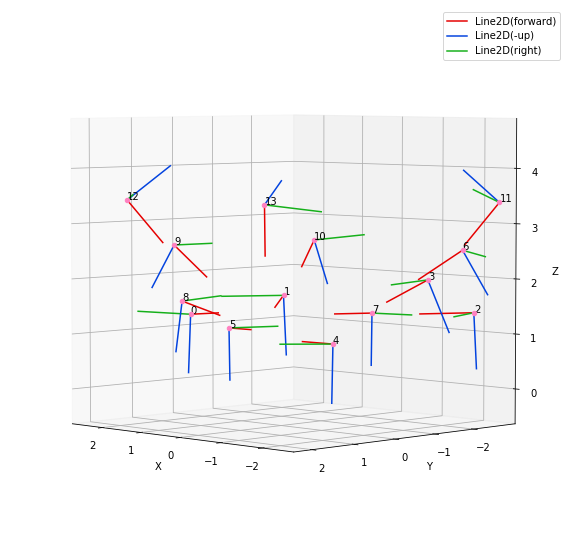

In [81]:
camera_transformation_matrix, camera_transformation_matrix_inv = record_camera_poses(new_dataset_loc, cam_c, cam_up, cam_right)
plot_all_camera_pos(torch.from_numpy(camera_transformation_matrix).float())

In [82]:
projection_client = Projection_Client(test_set=test_set_name, future_window_size=0, num_of_joints=15, 
                    intrinsics=cam_intrinsics, noise_2d_std=0, device=torch.device("cpu"))    
poses_3d_gt = transform_camera_coord_to_world_coord(camera_pose_matrix, camera_transformation_matrix, projection_client)
#print(poses_3d_gt[0:10,:,:])
for linecount in range(1000,1200, 10):
    #display_pose(poses_3d_gt.numpy()[linecount,:,:])
    pass

tensor([[1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008],
        [1.0343, 3.8231, 1.5008]])


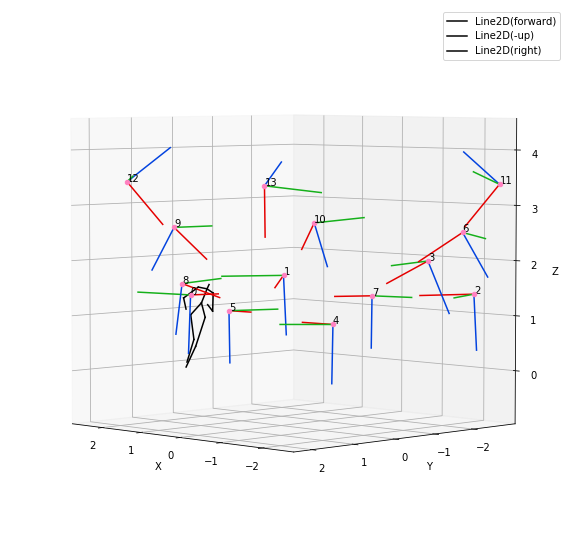

In [83]:
plot_all_camera_pos(torch.from_numpy(camera_transformation_matrix).float(), poses_3d_gt[1000,:,:])

In [84]:
save_poses(poses_3d_gt, new_dataset_loc)

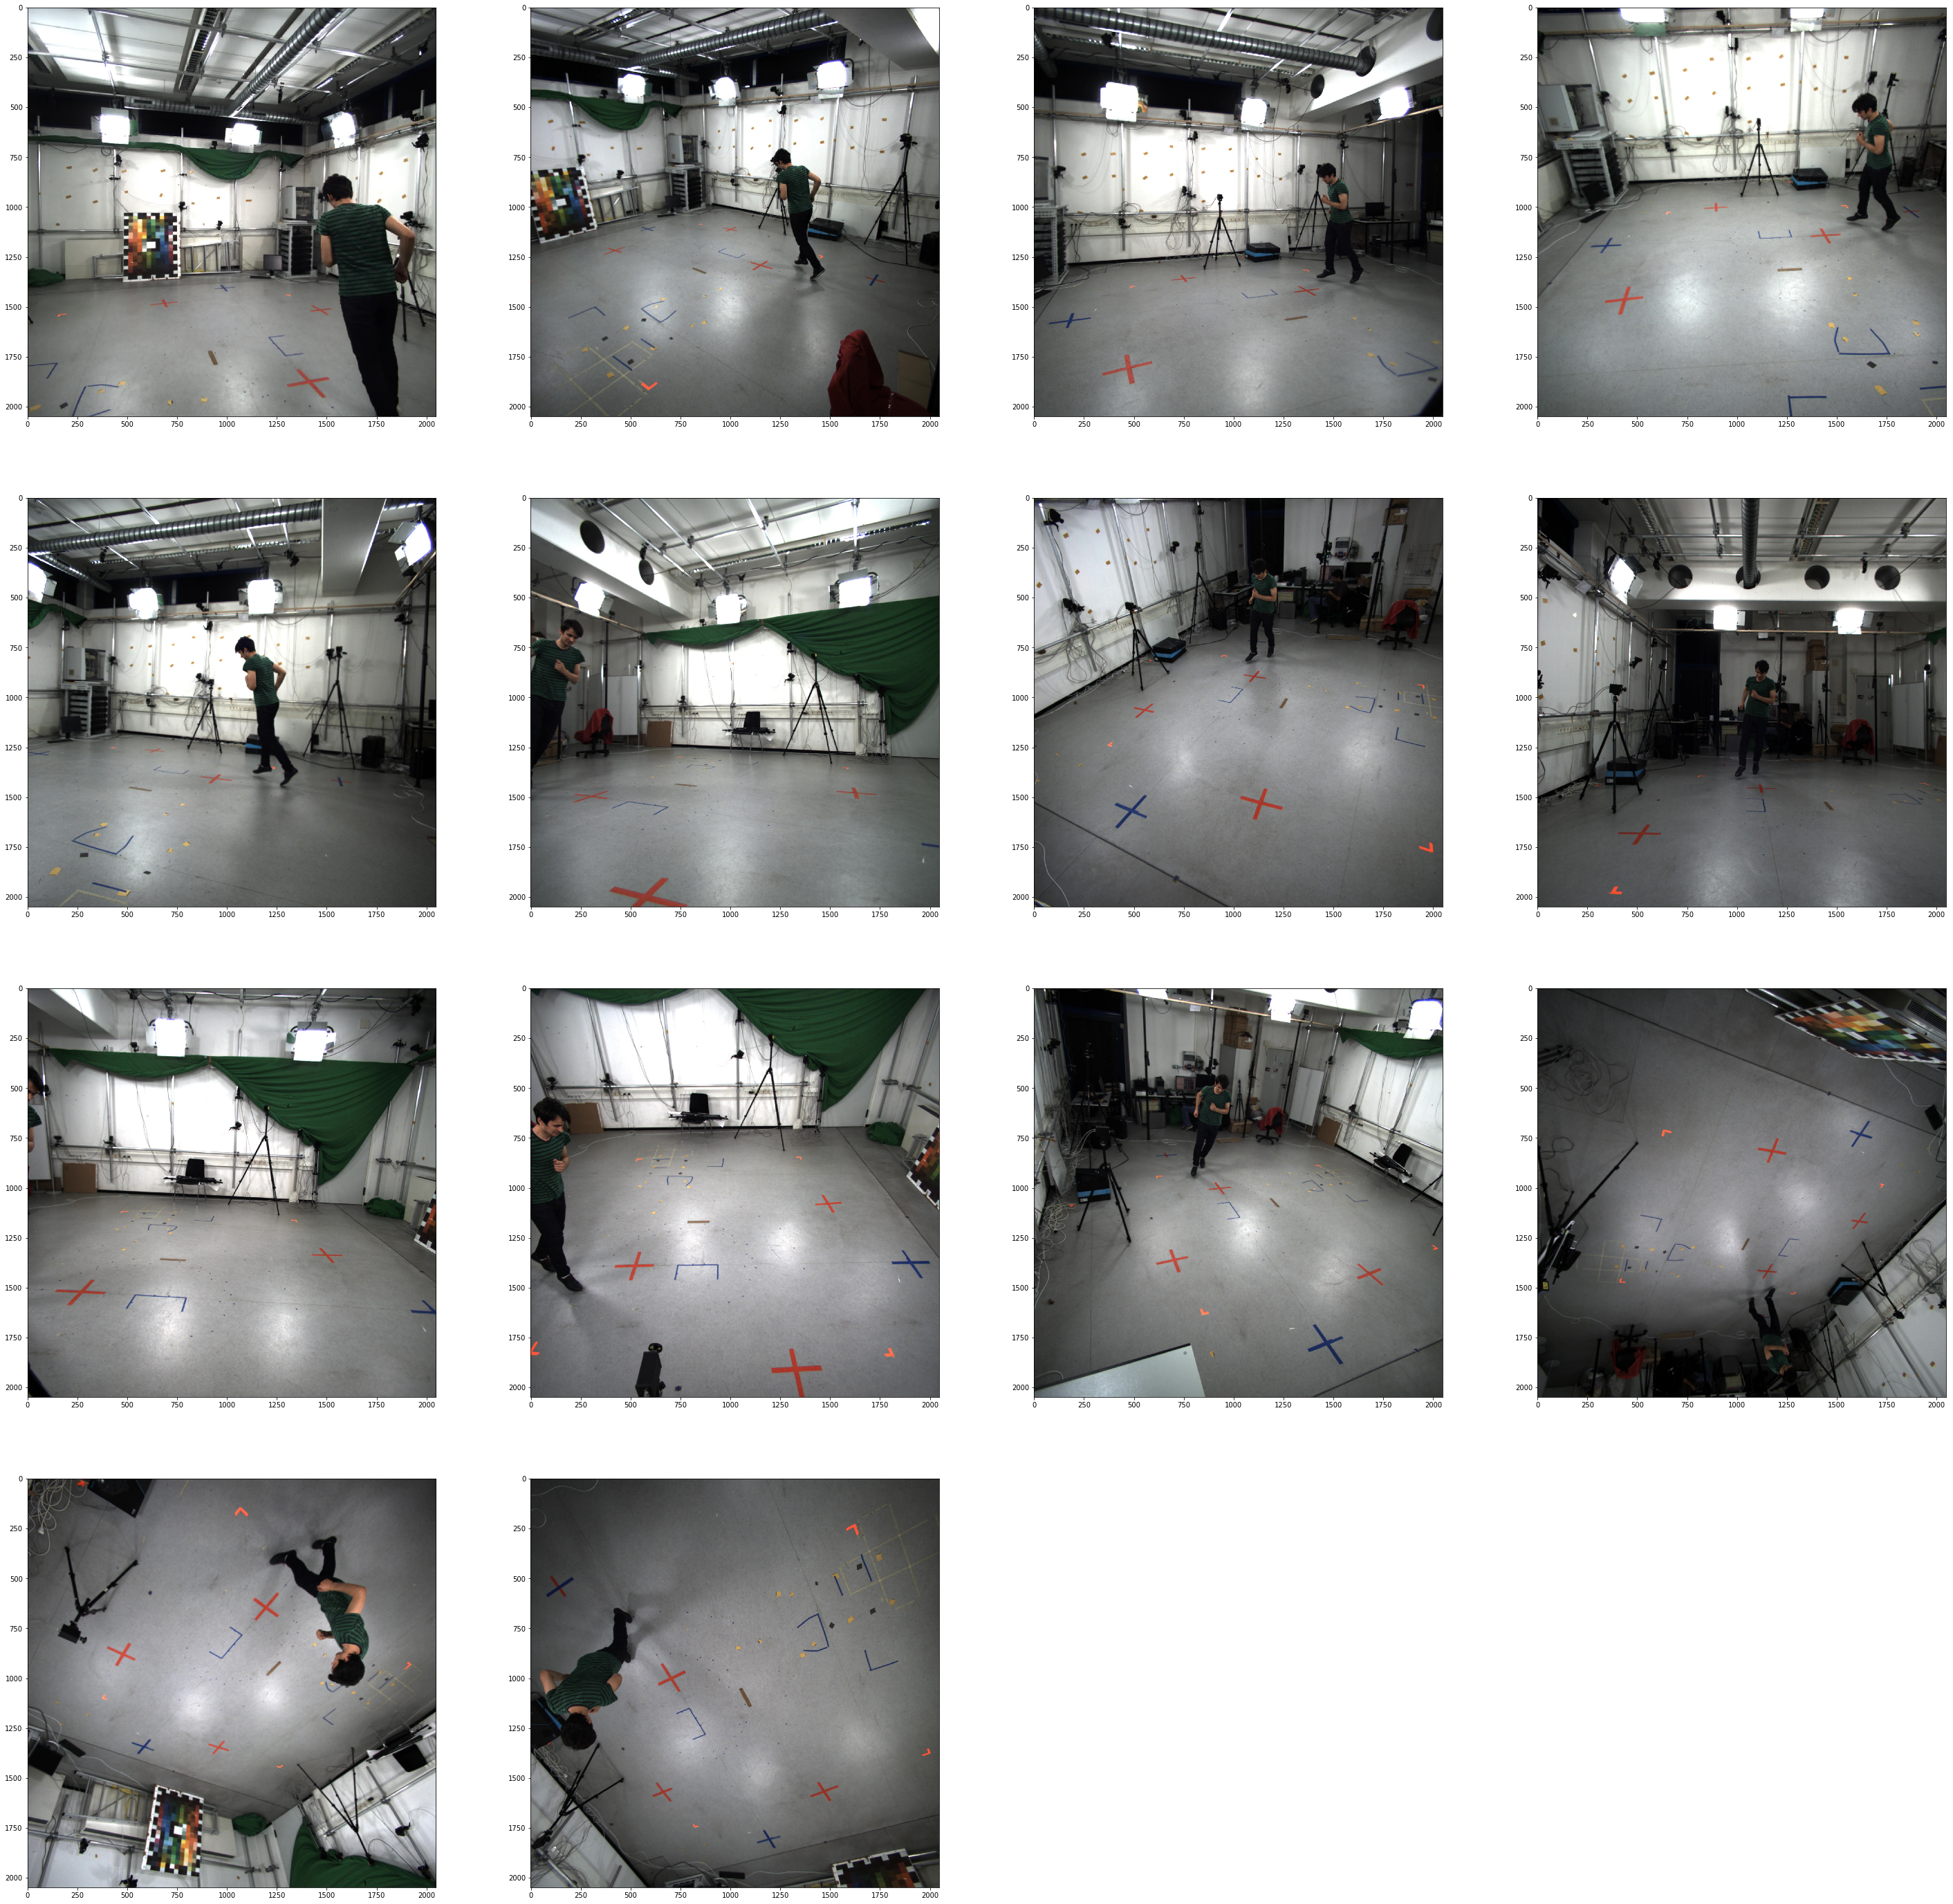

In [85]:
frame = 1000
plot_for_all_views(dataset_loc, frame)

In [ ]:
proj = take_projection(projection_client, poses_3d_gt[frame,:,:], camera_transformation_matrix_inv, cam_intrinsics)
plot_for_all_views_proj(dataset_loc, frame, (proj).numpy())

In [ ]:
print(proj)